In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
%matplotlib inline

In [4]:
T = np.array([[0.2, 0.4, 0.4], [0.3, 0.4, 0.3], [0.5, 0.5, 0.0]])

In [5]:
MSM = pyemma.msm.markov_model(T)

In [6]:
pyemmaMTT = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        pyemmaMTT[i,j] = MSM.mfpt(i,j)

In [7]:
length = 10000000

In [8]:
traj = np.zeros(length, dtype = int)
for i in range(1, length):
    traj[i] = np.random.choice(np.arange(3), p=T[traj[i-1], :])

In [9]:
def computeMeanTransitionTimes(dTrajs, timestep, Nstates):
    sumTau = np.zeros((Nstates, Nstates))
    counts = np.zeros((Nstates, Nstates))
    for dTraj in dTrajs:
        i = 0
        tau = 0
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            tau += 1
            if dTraj[i] != dTraj[i-1]:
                if len(statesVisited) == Nstates:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 0
                elif not np.in1d(dTraj[i], statesVisited):
                    sumTau[transitionFrom, dTraj[i]] += tau
                    counts[transitionFrom, dTraj[i]] += 1
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    statesVisited.append(dTraj[i])
    meanTransitionTimes = np.zeros((Nstates, Nstates))
    for i in range(0, Nstates):
        for j in range(0, Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [20]:
MTT = computeMeanTransitionTimes([traj], 1., 3)

In [11]:
print MTT-pyemmaMTT

[[ 0.          0.0009023  -0.0031473 ]
 [-0.00170312  0.         -0.00211872]
 [-0.00222391  0.00112339  0.        ]]


In [12]:
its = pyemma.msm.its(traj, lags = 50)

estimating MaximumLikelihoodMSM: 100% (9/9) [######################] eta 00:00 -

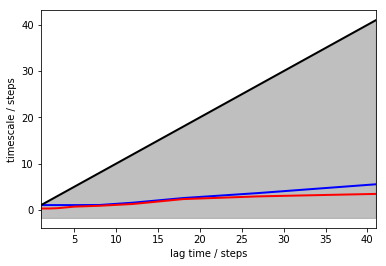

In [14]:
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)


In [13]:
M = pyemma.msm.estimate_markov_model(traj, 2, reversible=True)

In [14]:
estimatedMTT = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        estimatedMTT[i,j] = M.mfpt(i,j)

In [21]:
MTTstride = computeMeanTransitionTimes([traj[::2]], 2., 3)

In [26]:
print estimatedMTT - MTT #error HUGE
print estimatedMTT - MTTstride #error small

[[ 0.          2.31637103  6.42018996]
 [ 3.60114258  0.          5.7771839 ]
 [ 4.62779513  2.70030423  0.        ]]
[[ 0.          0.00274594 -0.00451689]
 [ 0.01201939  0.         -0.00287622]
 [ 0.02621661  0.00409542  0.        ]]


In [27]:
import pyemma.datasets

In [39]:
double_well_data = pyemma.datasets.load_2well_discrete()
dTrajs = double_well_data.generate_trajs(10, 1000000)

In [69]:
def milestoningDoubleWell(trajs):
    dTrajs = []
    for traj in trajs:
        dTraj = np.zeros(len(traj), dtype=int)
        for i in range(len(traj)):
            if traj[i]<50:
                dTraj[i] = 0
            else:
                dTraj[i] = 1
        dTrajs.append(dTraj)
    return dTrajs

# Let's use the double well model implemented in pyEmma to have a better data set

In [72]:
discreteTrajs = milestoningDoubleWell(dTrajs)

In [77]:
its = pyemma.msm.its(discreteTrajs, lags = 1000)

estimating MaximumLikelihoodMSM: 100% (16/16) [####################] eta 00:01 |

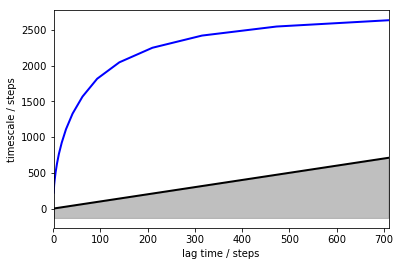

In [78]:
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)

Lagtime of 500 seems to be alright

In [81]:
MSM = pyemma.msm.estimate_markov_model(discreteTrajs, 500, reversible=True)

Compute mean transition times straight from markov model using pyemma

In [82]:
doubleWellMFPT = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        doubleWellMFPT[i,j] = MSM.mfpt(i,j)

Do a CK test, because we can. Results seems to be alright.

In [84]:
doubleWellCKTest = MSM.cktest(2)

estimating MaximumLikelihoodMSM: 100% (9/9) [######################] eta 00:00 |

(<matplotlib.figure.Figure at 0x7f3e5710d590>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e570c5550>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f3e551fc050>]], dtype=object))

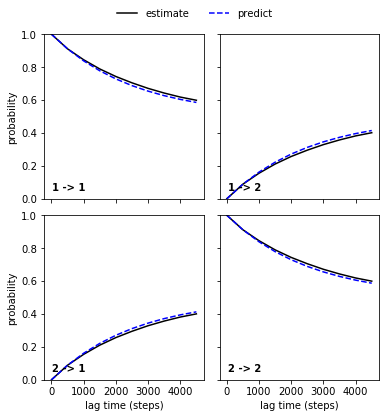

In [86]:
mplt.plot_cktest(doubleWellCKTest)

Compute mean transition times directly from the trajectory.
Here we see, that we are only able to reproduce the MTT of the markov model if we use a stride corresoponding to the lag time of the MSM. 

In [93]:
stridedDTrajs = []
stride = 500
for traj in discreteTrajs:
    stridedDTraj = traj[::500]
    stridedDTrajs.append(stridedDTraj)

In [101]:
doubleWellMFPTstrided = computeMeanTransitionTimes(stridedDTrajs, 500, 2)
doubleWellMFPTdirect = computeMeanTransitionTimes(discreteTrajs, 1, 2)

In this case there is one order of magnitute between the strieded and non-strided version of the mean first passage times.

In [102]:
print doubleWellMFPTdirect

[[   0.          444.68678673]
 [ 444.01087441    0.        ]]


In [103]:
print doubleWellMFPT

[[    0.          5645.59274387]
 [ 5621.92639314     0.        ]]


If we take the same lagtime between data points as in the markov model, both computational approaches seem to match neatly

In [99]:
print (doubleWellMFPTdirect - doubleWellMFPT)/doubleWellMFPT

[[        nan -0.0044214 ]
 [-0.00388015         nan]]


/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


Let's have a look, how the MFPTs behave with increasing lagtime. This looks awefully alot like the implied timescale plot. In this case, the timescales seem to coincide.

In [110]:
MTTs = []
for stride in range(1, 1001, 50):
    stridedDTrajs = []
    for traj in discreteTrajs:
        stridedDTraj = traj[::stride]
        stridedDTrajs.append(stridedDTraj)
    MTTs.append(computeMeanTransitionTimes(stridedDTrajs, stride, 2))

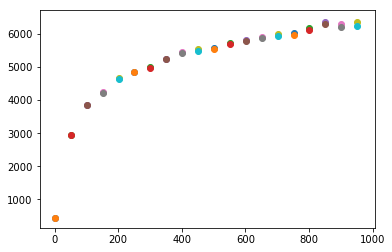

In [111]:
for i in range(len(MTTs)):
    plt.scatter(i*50+1, MTTs[i][0,1])
    plt.scatter(i*50+1, MTTs[i][1,0])

This means that in order to compare results between the two approaches, we have to stride the data according to the lagtime of the markov state model.

In this computation we count our mean transition times from the point in time at which we enter a state i until we reach a state  j. This might introduce a bias.
When thinking in terms of the original data, entereing state i from another state k has an influence on the probability of the next step, as at the original timestep, the data is not markovian.
In the simple double well potential, entering one state happens at the boundary. From this boundary, there is a higher probability of going back to the original state, than from anywhere else in this state, especially, there might occcur multiple recrossings, before the particle relaxes into one potential well.
When using a higher timestep, these recrossings are lost in the higher resolution. Thus resolving in a higher MFPT.

In order to compute the correct MFPT on the original data, we have to count all transitions from i to j, even if the particle stays in i for a while before going anywhere else. This ensures, that we sample from the correct distribution in state and not restrict ourselves to picking trajectories only from the boundary.